In [1]:
!pip install -q scikit-learn xgboost optuna "optuna-integration[xgboost]" joblib pandas numpy matplotlib seaborn shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 6.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import optuna
import joblib
import pathlib
import datetime
import warnings
import os
from IPython.display import display

# Suppress harmless warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# --- Configuration & Constants ---
TARGET_COLUMN = 'settlementvalue'

# Based on benchmark notebook using clean_df.csv
NOTEBOOK_REMOVE_VALUES_FROM = ['specialhealthexpenses','specialfixes','specialrehabilitation','specialadditionalinjury']
NOTEBOOK_DROP_COLUMNS = [
    'driverage','vehicleage','accidentdate','claimdate','policereportfiled',
    'witnesspresent','dominantinjury','vehicletype','weatherconditions','gender',
    'numberofpassengers', 'accidentdescription', 'injurydescription'
]
# These are the categorical columns the  benchmark notebook *explicitly drops* after other processing
NOTEBOOK_EXPLICIT_CAT_DROP = ['accidenttype','exceptionalcircumstances', 'minorpsychologicalinjury', 'whiplash']

# --- Preprocessing Functions ---

def apply_tariff_bands_cw(df_: pd.DataFrame):
    df = df_.copy()
    col_name = 'injuryprognosis'
    if col_name not in df.columns:
        warnings.warn(f"Column '{col_name}' not found for tariff banding. Skipping.")
        return df

    # Ensure the column is numeric for comparison, coercing errors
    df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
    # Fill NaNs before binning. Using a high value to fall into the last band.
    # This is a choice; consider if 0 or median is more appropriate for your data.
    df[col_name] = df[col_name].fillna(25)

    # Apply binning using conditions and choices for clarity
    conditions = [
        (df[col_name] <= 3),
        (df[col_name] >= 4) & (df[col_name] <= 6),
        (df[col_name] >= 7) & (df[col_name] <= 9),
        (df[col_name] >= 10) & (df[col_name] <= 12),
        (df[col_name] >= 13) & (df[col_name] <= 15),
        (df[col_name] >= 16) & (df[col_name] <= 18),
        (df[col_name] >= 19) & (df[col_name] <= 24),
        (df[col_name] >= 25)
    ]
    choices = [0, 1, 2, 3, 4, 5, 6, 7]
    df[col_name] = np.select(conditions, choices, default=7) # Default for any unhandled cases
    df[col_name] = df[col_name].astype(int) # Convert to int as per the benchmarking notebook
    return df

def drop_outlier_values_cw(df_: pd.DataFrame, outlier_cols: list):
    df = df_.copy()
    initial_rows = len(df)
    # Create a boolean mask for rows to KEEP. Initialize to all True.
    rows_to_keep_mask = pd.Series(True, index=df.index)

    for col in outlier_cols:
        if col in df.columns:
            # Ensure column is numeric before comparison
            # Fill NaNs with 0 for the purpose of this check (value != 0)
            numeric_col = pd.to_numeric(df[col], errors='coerce').fillna(0)
            # Update mask: keep rows where this column IS 0
            rows_to_keep_mask &= (numeric_col == 0)
        else:
            warnings.warn(f"Outlier check column '{col}' not found. Skipping.")

    df_filtered = df[rows_to_keep_mask]
    rows_dropped = initial_rows - len(df_filtered)
    if rows_dropped > 0:
        print(f"Dropped {rows_dropped} rows due to non-zero values in specified outlier columns: {outlier_cols}")
    return df_filtered


def drop_unwanted_columns_cw(df_: pd.DataFrame, cols_to_drop_list: list):
    df = df_.copy()
    existing_cols_to_drop = [col for col in cols_to_drop_list if col in df.columns]
    if existing_cols_to_drop:
        df = df.drop(columns=existing_cols_to_drop)
        print(f"Dropped general unwanted columns: {existing_cols_to_drop}")
    return df

def preprocess_data(raw_df: pd.DataFrame) -> pd.DataFrame:
    print("--- Starting Preprocessing ---")
    df = raw_df.copy()
    initial_total_rows = len(df)

    # Standardize column names to lowercase
    df.columns = df.columns.str.lower()
    print(f"Columns converted to lowercase. Example: {df.columns[:5].tolist()}")

    # 0. Handle Target Column NaNs early
    if TARGET_COLUMN not in df.columns:
        raise ValueError(f"Target column '{TARGET_COLUMN}' not found in initial dataframe after lowercasing.")
    if df[TARGET_COLUMN].isnull().any():
        print(f"Initial NaNs in target '{TARGET_COLUMN}': {df[TARGET_COLUMN].isnull().sum()}. Dropping these rows.")
        df.dropna(subset=[TARGET_COLUMN], inplace=True)
        if df.empty:
            raise ValueError("Preprocessing resulted in an empty DataFrame after dropping target NaNs.")
    print(f"Shape after target NaN drop: {df.shape}")

    # 1. Drop rows with outlier values based on list
    df = drop_outlier_values_cw(df, NOTEBOOK_REMOVE_VALUES_FROM)
    print(f"Shape after drop_outlier_values: {df.shape}")
    if df.empty:
        warnings.warn("DataFrame empty after drop_outlier_values. No data to proceed.")
        return pd.DataFrame()

    # 2. Drop general unwanted columns
    df = drop_unwanted_columns_cw(df, NOTEBOOK_DROP_COLUMNS)
    print(f"Shape after initial drop_unwanted_columns: {df.shape}")

    # 3. Apply tariff bands to 'injuryprognosis'
    df = apply_tariff_bands_cw(df) # This also handles 'injuryprognosis' NaNs by filling then binning
    print(f"Shape after apply_tariff_bands: {df.shape}")
    if 'injuryprognosis' in df.columns:
        print(f"  'injuryprognosis' dtype: {df['injuryprognosis'].dtype}, unique values: {np.unique(df['injuryprognosis']).tolist()}")
    if df.empty: # Check if empty after tariff bands (e.g. if all injuryprognosis were NaN and not handled well by fillna)
        warnings.warn("DataFrame empty after applying tariff bands. No data to proceed.")
        return pd.DataFrame()

    # 4. Explicitly drop other categorical columns
    # These are columns that were NOT one-hot encoded but simply removed in the benchmark.
    df = drop_unwanted_columns_cw(df, NOTEBOOK_EXPLICIT_CAT_DROP)
    print(f"Shape after dropping explicit categorical columns like 'accidenttype': {df.shape}")

    # 5. Handle remaining NaNs in features
    # At this stage, all features should ideally be numeric.
    feature_cols = df.columns.drop(TARGET_COLUMN, errors='ignore')
    for col in feature_cols:
        if df[col].isnull().any():
            nan_count = df[col].isnull().sum()
            if pd.api.types.is_numeric_dtype(df[col]):
                fill_value = df[col].median()
                print(f"Filling {nan_count} NaNs in numeric feature '{col}' with median: {fill_value}")
                df[col].fillna(fill_value, inplace=True)
            else:
                # This case should ideally not be hit if all categoricals were dropped or handled (like injuryprognosis)
                fill_value = df[col].mode()
                fill_value = fill_value[0] if not fill_value.empty else 'Unknown'
                print(f"Filling {nan_count} NaNs in non-numeric feature '{col}' with mode: {fill_value}")
                df[col].fillna(fill_value, inplace=True)
                # If it's still not numeric, it's an issue.
                if not pd.api.types.is_numeric_dtype(df[col]):
                    warnings.warn(f"Feature '{col}' remains non-numeric (dtype: {df[col].dtype}) after attempting mode fill. This might cause issues. Consider explicit conversion or dropping.")
                    # As a fallback, try to convert to numeric, coercing errors, then fill again
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    if df[col].isnull().any():
                        df[col].fillna(df[col].median(), inplace=True) # Or 0, or drop

    # NO SCALER.
    final_feature_count = len(df.columns) - (1 if TARGET_COLUMN in df.columns else 0)
    print(f"--- Preprocessing Complete. Final DataFrame shape: {df.shape} ---")
    print(f"Total rows removed during preprocessing: {initial_total_rows - len(df)}")
    print(f"Final features count: {final_feature_count}")
    return df

# --- Log Transformation Functions ---
def log_convert_target(y_series: pd.Series) -> pd.Series:
    return np.log1p(y_series)

def inverse_log_convert_target(y_log_series: pd.Series) -> pd.Series:
    # Ensure input is a Series for correct expm1 application and output type
    y_log_series = pd.Series(y_log_series) if isinstance(y_log_series, np.ndarray) else y_log_series
    return np.expm1(y_log_series)

In [4]:
# --- Data Loading and Splitting --
csv_path = "clean_df.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(
        f"'{csv_path}' not found. Please upload it to the current directory "
        "or specify the correct path."
    )

print(f"Loading raw data from: {csv_path}...")
X_train, X_test, y_train, y_test, y_train_log, y_test_log, feature_names = [None]*7 # Initialize

try:
    raw_df = pd.read_csv(csv_path)
    print(f"Raw data loaded: {raw_df.shape}")
    print(f"Raw data columns (first 5): {raw_df.columns[:5].tolist()}")

    # Create a copy for preprocessing to leave raw_df untouched if needed later
    processed_df = preprocess_data(raw_df.copy())

    if processed_df.empty:
        raise ValueError("Preprocessing resulted in an empty DataFrame.")
    if TARGET_COLUMN not in processed_df.columns:
        raise ValueError(f"Target column '{TARGET_COLUMN}' missing after preprocessing.")

    X = processed_df.drop(TARGET_COLUMN, axis=1)
    y = processed_df[TARGET_COLUMN] # Original scale target

    # Ensure target is numeric (should be, but good check)
    if not pd.api.types.is_numeric_dtype(y):
        warnings.warn(f"Target '{TARGET_COLUMN}' not numeric after preprocessing. Attempting conversion.")
        y = pd.to_numeric(y, errors='coerce')
        if y.isnull().any():
            y_nan_count = y.isnull().sum()
            y_median_fill = y.median()
            y = y.fillna(y_median_fill)
            warnings.warn(f"Filled {y_nan_count} NaNs in target with median ({y_median_fill}) after numeric conversion.")

    # Ensure all features are numeric (they should be after the new preprocessing)
    non_numeric_features = X.select_dtypes(exclude=[np.number]).columns
    if not non_numeric_features.empty:
        warnings.warn(f"Non-numeric features still present in X after preprocessing: {non_numeric_features.tolist()}. This is unexpected. Dropping them.")
        X = X.select_dtypes(include=[np.number])

    # Final check for NaNs in features X just before split
    if X.isnull().values.any():
        nan_cols_X = X.columns[X.isnull().any()].tolist()
        warnings.warn(f"NaNs detected in features X just before split: {nan_cols_X}. This is highly unexpected. Review preprocessing's NaN handling. Attempting median fill as a last resort.")
        for col in nan_cols_X:
            if pd.api.types.is_numeric_dtype(X[col]): # Should be true
                 X[col].fillna(X[col].median(), inplace=True)
            else: # Should not happen
                 X[col].fillna(0, inplace=True) # Or some other default for non-numeric

    if X.empty or y.empty:
        raise ValueError("X or y is empty before train/test split. Check data and preprocessing.")
    if len(X) != len(y):
        raise ValueError(f"X ({len(X)}) and y ({len(y)}) have mismatched lengths before split.")

    print(f"Final shapes for splitting: X={X.shape}, y={y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=processed_df['injuryprognosis'] if 'injuryprognosis' in processed_df else None
    )

    # Log transform the target for training and for XGBoost's eval set
    y_train_log = log_convert_target(y_train.copy())
    y_test_log = log_convert_target(y_test.copy()) # Used for XGBoost eval_set

    print("Data split complete.")
    print(f"Train shapes: X_train={X_train.shape}, y_train_log={y_train_log.shape}")
    print(f"Test shapes:  X_test={X_test.shape}, y_test (original scale)={y_test.shape}, y_test_log={y_test_log.shape}")

    feature_names = X.columns.tolist()
    print(f"Number of features: {len(feature_names)}")
    print(f"Feature names: {feature_names}")

except FileNotFoundError as e_fnf:
    print(f"❌ Data loading error: {e_fnf}")
except ValueError as e_val:
    print(f"❌ Data/Preprocessing/validation error: {e_val}")
    import traceback
    traceback.print_exc()
except Exception as e_exc:
    print(f"❌ Unexpected error during data prep: {e_exc}")
    import traceback
    traceback.print_exc()
    # Re-raise to halt execution if data prep fails critically
    # raise

Loading raw data from: clean_df.csv...
Raw data loaded: (4874, 36)
Raw data columns (first 5): ['settlementvalue', 'injuryprognosis', 'injurydescription', 'dominantinjury', 'whiplash']
--- Starting Preprocessing ---
Columns converted to lowercase. Example: ['settlementvalue', 'injuryprognosis', 'injurydescription', 'dominantinjury', 'whiplash']
Shape after target NaN drop: (4874, 36)
Dropped 37 rows due to non-zero values in specified outlier columns: ['specialhealthexpenses', 'specialfixes', 'specialrehabilitation', 'specialadditionalinjury']
Shape after drop_outlier_values: (4837, 36)
Dropped general unwanted columns: ['driverage', 'vehicleage', 'accidentdate', 'claimdate', 'policereportfiled', 'witnesspresent', 'dominantinjury', 'vehicletype', 'weatherconditions', 'gender', 'numberofpassengers', 'accidentdescription', 'injurydescription']
Shape after initial drop_unwanted_columns: (4837, 23)
Shape after apply_tariff_bands: (4837, 23)
  'injuryprognosis' dtype: int64, unique values: 

In [5]:
# --- Metric Calculation Function (MODIFIED for RMSE compatibility) ---
def metric_row(model, name: str, X_eval: pd.DataFrame, y_eval_original: pd.Series,
               log_transformed_target: bool = False) -> dict:
    # Ensure y_eval_original has an index if it's an array, or X_eval might complain
    if not isinstance(y_eval_original, pd.Series):
        y_eval_original = pd.Series(y_eval_original)
    if X_eval.index.name != y_eval_original.index.name: # Ensure indices match if named
        X_eval = X_eval.reset_index(drop=True)
        y_eval_original = y_eval_original.reset_index(drop=True)


    preds_model_scale = model.predict(X_eval) # Predictions are on log scale if model trained on log target

    if log_transformed_target:
        # Ensure preds_model_scale is a Series with the correct index for inverse_log_convert_target
        if isinstance(preds_model_scale, np.ndarray):
            # Align index with y_eval_original for correct inverse transform pairing
            preds_model_scale_series = pd.Series(preds_model_scale, index=y_eval_original.index)
        else: # Assuming Pandas Series from some frameworks
            preds_model_scale_series = preds_model_scale.copy()
            if preds_model_scale_series.index.name != y_eval_original.index.name:
                 preds_model_scale_series = preds_model_scale_series.reset_index(drop=True)


        preds_original_scale = inverse_log_convert_target(preds_model_scale_series)
    else:
        preds_original_scale = pd.Series(preds_model_scale, index=y_eval_original.index) if isinstance(preds_model_scale, np.ndarray) else preds_model_scale


    # Clip predictions to avoid negative values (e.g. from expm1 if log_preds were very small negative)
    # Also ensures y_eval_original and preds_original_scale are numpy arrays for metric functions
    preds_original_scale = np.maximum(0, preds_original_scale.values if isinstance(preds_original_scale, pd.Series) else preds_original_scale)
    y_eval_original_values = y_eval_original.values if isinstance(y_eval_original, pd.Series) else y_eval_original


    # Calculate RMSE: sqrt(MSE).
    # The 'squared' argument might not be available in older scikit-learn versions.
    mse = mean_squared_error(y_eval_original_values, preds_original_scale)
    rmse = np.sqrt(mse)

    return {
        "Model": name,
        "MAE": mean_absolute_error(y_eval_original_values, preds_original_scale),
        "RMSE": rmse,
        "R2": r2_score(y_eval_original_values, preds_original_scale)
    }

In [6]:
# --- Random Forest Tuning & Training ---
if X_train is None or y_train_log is None:
    raise RuntimeError("X_train or y_train_log not defined. Run data preparation cell first.")

print("\n--- Tuning RandomForestRegressor (MAE on log scale) ---")
cv_rf = KFold(n_splits=5, shuffle=True, random_state=42)
# Optuna minimizes. MAE: lower is better. So we return MAE directly (or -MAE if using a maximizer).
# make_scorer by default wants higher_is_better=True for scores.
# For MAE, we want lower is better, so cross_val_score will return negative MAE.
# Thus, rf_objective should return this negative MAE or -(its positive version).
# My original was: return -scores.mean() where scores were already negative MAE. So return scores.mean() (which is negative)
# OR: mae_scorer_rf = make_scorer(mean_absolute_error, greater_is_better=False)
# scores = cross_val_score(..., scoring=mae_scorer_rf) -> scores are negative MAE.
# Objective: return np.mean(scores) -> which is negative MAE, optuna minimizes this (good)
# OR: if we want to return positive MAE for optuna to minimize:
# mae_scorer_rf_positive = make_scorer(mean_absolute_error)
# scores = cross_val_score(..., scoring=mae_scorer_rf_positive) -> scores are positive MAE.
# Objective: return np.mean(scores) -> optuna minimizes this (good)

mae_scorer_for_cv = make_scorer(mean_absolute_error, greater_is_better=False)

def rf_objective(trial: optuna.trial.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("trees", 100, 800, step=100), # Reduced upper for speed
        "max_depth": trial.suggest_int("depth", 5, 25),
        "min_samples_split": trial.suggest_int("min_split", 2, 15),
        "min_samples_leaf": trial.suggest_int("min_leaf", 1, 10),
        "max_features": trial.suggest_categorical("mfeat", ["sqrt", "log2", 0.4, 0.7]), # Adjusted
        "bootstrap": trial.suggest_categorical("boot", [True, False]),
        "random_state": 42,
        "n_jobs": -1,
    }
    model = RandomForestRegressor(**params)
    # cross_val_score with a 'greater_is_better=False' scorer will return negative values.
    # Optuna's 'minimize' direction means it tries to find params that result in the smallest return value.
    # So, if scores.mean() is, e.g., -0.1 (for an MAE of 0.1), Optuna will try to make it more negative (e.g. -0.05).
    # This is correct.
    scores = cross_val_score(
        model, X_train, y_train_log, cv=cv_rf, scoring=mae_scorer_for_cv, n_jobs=-1
    )
    return np.mean(scores) # Return the mean of (negative) MAE scores. Optuna will minimize this value.

study_rf_name = "rf_mae_log_cv_final"
study_rf = optuna.create_study(direction="maximize", study_name=study_rf_name) # Maximize the negative MAE
# If study_rf.optimize returns e.g. -0.05, then best_value is -0.05, actual MAE is 0.05
# If direction="minimize" and objective returns positive MAE, then best_value is 0.05. This is simpler.

# Let's stick to Optuna minimizing a positive MAE for clarity.
# So the objective should return a positive MAE.
# And mae_scorer_for_cv should have greater_is_better=True (default for MAE isn't, so must be explicit or use loss function)

# Redefining for clarity:
# We want to minimize MAE. Optuna minimizes the objective's return value.
# So, objective should return MAE (a positive value).
def rf_objective_min_mae(trial: optuna.trial.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("trees", 100, 800, step=100),
        "max_depth": trial.suggest_int("depth", 5, 25),
        "min_samples_split": trial.suggest_int("min_split", 2, 15),
        "min_samples_leaf": trial.suggest_int("min_leaf", 1, 10),
        "max_features": trial.suggest_categorical("mfeat", ["sqrt", "log2", 0.4, 0.7]),
        "bootstrap": trial.suggest_categorical("boot", [True, False]),
        "random_state": 42,
        "n_jobs": -1,
    }
    model = RandomForestRegressor(**params)
    # Use a scorer that returns positive MAE, but tell cross_val_score it's a loss function (lower is better)
    # Or, more simply, calculate MAE manually in a loop.
    # Optuna default direction is "minimize".
    # For cross_val_score, if scoring is a loss function (like 'neg_mean_absolute_error'), it returns negated scores.
    # If we use 'neg_mean_absolute_error', scores will be negative (e.g., -0.1 for MAE 0.1).
    # Objective returns scores.mean() (e.g., -0.1). Optuna minimizes this, trying to get -0.05 (better MAE). This is correct.
    scores = cross_val_score(
        model, X_train, y_train_log, cv=cv_rf, scoring='neg_mean_absolute_error', n_jobs=-1
    )
    return np.mean(scores) # Optuna will maximize this (e.g. from -0.1 to -0.05)

study_rf = optuna.create_study(direction="maximize", study_name=study_rf_name) # Maximize neg_mean_absolute_error
study_rf.optimize(rf_objective_min_mae, n_trials=25, show_progress_bar=True) # n_trials reduced

# study_rf.best_value will be the max negative MAE (e.g., -0.05)
# Actual best MAE is -study_rf.best_value
print(f"RF best MAE (log scale CV): {-study_rf.best_value:.4f}")
print(f"Best params: {study_rf.best_params}")

bp_rf = study_rf.best_params
rf_best = RandomForestRegressor(
    n_estimators=bp_rf["trees"], max_depth=bp_rf["depth"],
    min_samples_split=bp_rf["min_split"], min_samples_leaf=bp_rf["min_leaf"],
    max_features=bp_rf["mfeat"], bootstrap=bp_rf["boot"],
    random_state=42, n_jobs=-1,
)
rf_best.fit(X_train, y_train_log)
print("✅ RF fitted with best params.")

[I 2025-05-07 20:03:27,731] A new study created in memory with name: rf_mae_log_cv_final
[I 2025-05-07 20:03:27,737] A new study created in memory with name: rf_mae_log_cv_final



--- Tuning RandomForestRegressor (MAE on log scale) ---


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-05-07 20:03:36,200] Trial 0 finished with value: -0.1697815419301501 and parameters: {'trees': 100, 'depth': 19, 'min_split': 7, 'min_leaf': 9, 'mfeat': 'log2', 'boot': False}. Best is trial 0 with value: -0.1697815419301501.
[I 2025-05-07 20:03:44,920] Trial 1 finished with value: -0.16126781991352657 and parameters: {'trees': 300, 'depth': 7, 'min_split': 10, 'min_leaf': 4, 'mfeat': 0.4, 'boot': False}. Best is trial 1 with value: -0.16126781991352657.
[I 2025-05-07 20:04:04,148] Trial 2 finished with value: -0.1472196883912311 and parameters: {'trees': 700, 'depth': 10, 'min_split': 13, 'min_leaf': 10, 'mfeat': 0.7, 'boot': True}. Best is trial 2 with value: -0.1472196883912311.
[I 2025-05-07 20:04:05,590] Trial 3 finished with value: -0.14343923466508587 and parameters: {'trees': 100, 'depth': 20, 'min_split': 13, 'min_leaf': 5, 'mfeat': 'log2', 'boot': False}. Best is trial 3 with value: -0.14343923466508587.
[I 2025-05-07 20:04:07,055] Trial 4 finished with value: -0.1581

In [7]:
# --- XGBoost Tuning & Training ---
if X_train is None or y_train_log is None or X_test is None or y_test_log is None:
    raise RuntimeError("Required data not defined for XGBoost. Run previous cells.")

print("\n--- Tuning XGBoost (MAE on log scale) ---")
cv_xgb = KFold(n_splits=5, shuffle=True, random_state=42)

# Optuna minimizes the objective's return value. We want to minimize MAE.
# So, xgb_objective should return positive MAE.
def xgb_objective(trial: optuna.trial.Trial) -> float:
    params = {
        "objective": "reg:squarederror", # For regression, XGBoost optimizes MSE internally
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 9), # Adjusted range
        "min_child_weight": trial.suggest_float("min_child_weight", 0.1, 9.0, log=True), # Adjusted
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("lambda", 1e-7, 4.0, log=True), # Adjusted
        "reg_alpha": trial.suggest_float("alpha", 1e-7, 4.0, log=True), # Adjusted
        "n_estimators": 2500, # Fixed high, rely on early stopping
        "eval_metric": "mae", # XGBoost will use MAE for early stopping and report it
        "early_stopping_rounds": 75, # Adjusted
    }
    # No "enable_categorical" needed as 'injuryprognosis' is int and others are dropped.

    fold_mae_log_scale = []
    for tr_idx, val_idx in cv_xgb.split(X_train, y_train_log):
        X_tr_fold, X_val_fold = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr_log_fold, y_val_log_fold = y_train_log.iloc[tr_idx], y_train_log.iloc[val_idx]

        model_xgb = xgb.XGBRegressor(**params)
        model_xgb.fit(X_tr_fold, y_tr_log_fold,
                      eval_set=[(X_val_fold, y_val_log_fold)],
                      verbose=False)
        # Get predictions from the best iteration
        preds_log_scale = model_xgb.predict(X_val_fold, iteration_range=(0, model_xgb.best_iteration + 1 if model_xgb.best_iteration > 0 else params['n_estimators']))
        fold_mae_log_scale.append(mean_absolute_error(y_val_log_fold, preds_log_scale))
    return np.mean(fold_mae_log_scale) # Return positive MAE

study_xgb_name = "xgb_mae_log_cv_final"
study_xgb = optuna.create_study(direction="minimize", study_name=study_xgb_name)
study_xgb.optimize(xgb_objective, n_trials=20, show_progress_bar=True) # n_trials reduced

print(f"XGB best CV-MAE (log scale): {study_xgb.best_value:.4f}")
print(f"XGB best params: {study_xgb.best_params}")

final_xgb_params = {
    **study_xgb.best_params,
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "random_state": 42,
    "n_jobs": -1,
    "n_estimators": 3000, # Higher for final model
    "eval_metric": "mae",
    "early_stopping_rounds": 100, # More patient for final model
}
# No "enable_categorical" needed

best_xgb = xgb.XGBRegressor(**final_xgb_params)
# Use y_test_log for the evaluation set, which is also log-transformed
best_xgb.fit(X_train, y_train_log, eval_set=[(X_test, y_test_log)], verbose=False)
print("✅ XGBoost fitted with best params.")

[I 2025-05-07 20:08:34,933] A new study created in memory with name: xgb_mae_log_cv_final



--- Tuning XGBoost (MAE on log scale) ---


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-07 20:08:59,375] Trial 0 finished with value: 0.10521562811608157 and parameters: {'learning_rate': 0.0029603109993907406, 'max_depth': 6, 'min_child_weight': 0.6470568363893949, 'subsample': 0.5816678610371393, 'colsample_bytree': 0.7151565213090789, 'lambda': 0.004621467280012978, 'alpha': 0.647103216782763}. Best is trial 0 with value: 0.10521562811608157.
[I 2025-05-07 20:09:16,843] Trial 1 finished with value: 0.17787685180143326 and parameters: {'learning_rate': 0.001469368353412196, 'max_depth': 3, 'min_child_weight': 0.10768992144141601, 'subsample': 0.6602160925652498, 'colsample_bytree': 0.7760186967849997, 'lambda': 1.1978796800043183, 'alpha': 1.6757061609212285e-07}. Best is trial 0 with value: 0.10521562811608157.
[I 2025-05-07 20:09:30,060] Trial 2 finished with value: 0.11724202642763078 and parameters: {'learning_rate': 0.013784355518353397, 'max_depth': 3, 'min_child_weight': 8.952907201546607, 'subsample': 0.604728581428978, 'colsample_bytree': 0.734977704

In [8]:
# --- Evaluation and Saving ---
results_list = []
rf_model_available = 'rf_best' in locals() and rf_best is not None
xgb_model_available = 'best_xgb' in locals() and best_xgb is not None

if rf_model_available:
    try:
        results_list.append(metric_row(rf_best, "RandomForest", X_test, y_test, log_transformed_target=True))
    except Exception as e:
        print(f"Error evaluating RandomForest: {e}")
if xgb_model_available:
    try:
        results_list.append(metric_row(best_xgb, "XGBoost", X_test, y_test, log_transformed_target=True))
    except Exception as e:
        print(f"Error evaluating XGBoost: {e}")


if not results_list:
    warnings.warn("No models were successfully evaluated. Skipping results display and saving.")
    # You might want to raise an error or handle this differently
    # For now, we'll just print a warning and not proceed with champion logic.
    champ_model = None # Ensure champ_model is defined
else:
    results_df = pd.DataFrame(results_list).sort_values("MAE")
    print("\n--- Model Evaluation Results (Original Scale) ---")
    display(results_df.style.format({"MAE": "{:.2f}", "RMSE": "{:.2f}", "R2": "{:.3f}"}))

    if not results_df.empty:
        champ_name = results_df.iloc[0]["Model"]
        model_map = {}
        if rf_model_available: model_map["RandomForest"] = rf_best
        if xgb_model_available: model_map["XGBoost"] = best_xgb

        champ_model = model_map.get(champ_name)

        if champ_model is None:
            warnings.warn(f"Champion model '{champ_name}' logic failed, but results exist.")
            # Fallback or decide how to handle if the best model isn't in map (shouldn't happen)
            # For now, just try to save what's available if anything.
        else:
            print(f"\n🏆 Champion Model → {champ_name} (MAE: {results_df.iloc[0]['MAE']:.2f})")
    else: # results_df is empty even if results_list wasn't (e.g. if metric_row failed for all)
        warnings.warn("Results DataFrame is empty. Cannot determine champion.")
        champ_model = None


# Save models even if champion logic had an issue, as long as models exist
models_dir = pathlib.Path("models_cleaned_final")
models_dir.mkdir(exist_ok=True)
current_time_stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

saved_any_model = False
if rf_model_available:
    joblib.dump(rf_best, models_dir / f"random_forest_{current_time_stamp}.pkl")
    print(f"✔️ RandomForest model saved.")
    saved_any_model = True
if xgb_model_available:
    joblib.dump(best_xgb, models_dir / f"xgboost_{current_time_stamp}.pkl")
    print(f"✔️ XGBoost model saved.")
    saved_any_model = True

if champ_model is not None and champ_name in model_map : # champ_name must be valid from results_df
    joblib.dump(champ_model, models_dir / f"champion_{champ_name}_{current_time_stamp}.pkl")
    print(f"✔️ Champion model ({champ_name}) saved.")
    saved_any_model = True
elif saved_any_model: # If champ_model logic failed but other models saved
    print(f"Models saved in: {models_dir.resolve()}, but champion model determination had an issue.")
elif not saved_any_model:
    print("No models were available or saved.")

if saved_any_model and champ_model is not None :
     print(f"✔️ All relevant model PKLs saved in: {models_dir.resolve()}")
elif saved_any_model:
     print(f"✔️ Some model PKLs saved in: {models_dir.resolve()}")


--- Model Evaluation Results (Original Scale) ---


,Model,MAE,RMSE,R2
1,XGBoost,52.23,172.29,0.953
0,RandomForest,72.40,177.72,0.950



🏆 Champion Model → XGBoost (MAE: 52.23)
✔️ RandomForest model saved.
✔️ XGBoost model saved.
✔️ Champion model (XGBoost) saved.
✔️ All relevant model PKLs saved in: /content/models_cleaned_final



--- Additional Evaluation for Model: RandomForest ---
MAPE (Mean Absolute Percentage Error): 5.66%
RMSLE (Root Mean Squared Log Error): 0.1307


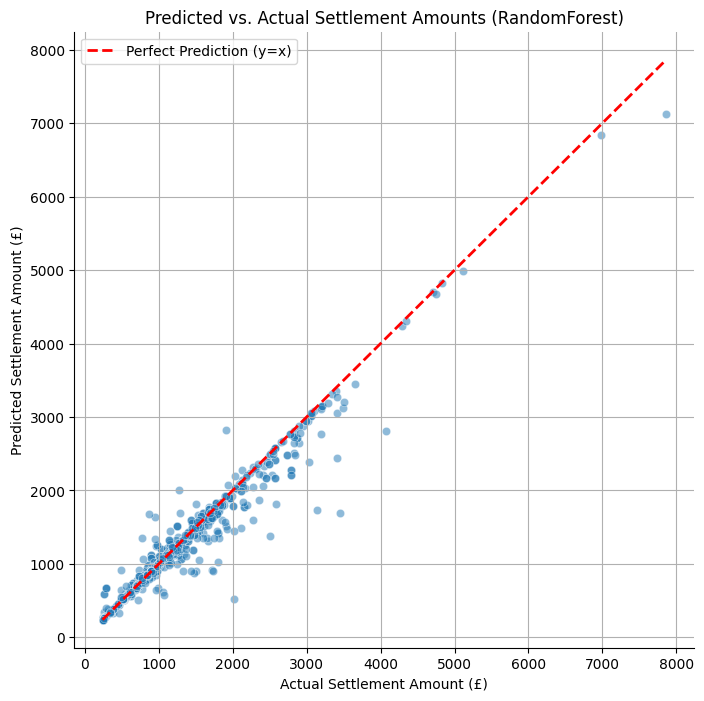


--- Additional Evaluation for Model: XGBoost ---
MAPE (Mean Absolute Percentage Error): 4.41%
RMSLE (Root Mean Squared Log Error): 0.1283


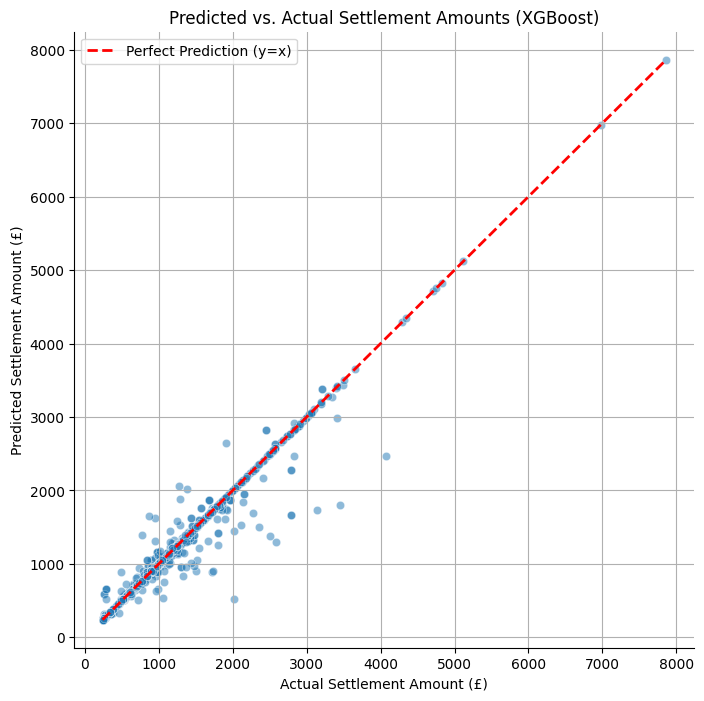

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error

# --- Define a helper function for evaluation ---
def evaluate_model_additionally(model, model_name_str: str, X_eval: pd.DataFrame, y_eval_original: pd.Series):
    print(f"\n--- Additional Evaluation for Model: {model_name_str} ---")

    # Make a copy of y_eval_original to work with for alignment
    y_eval_original_aligned = y_eval_original.copy()

    # Get predictions on the original scale
    log_preds_eval = model.predict(X_eval)

    # Inverse transform predictions to original currency scale
    if isinstance(log_preds_eval, np.ndarray):
        # If log_preds_eval is an array, ensure its Series conversion aligns with y_eval_original_aligned's index
        log_preds_eval_series = pd.Series(log_preds_eval, index=y_eval_original_aligned.index)
    else: # Assuming log_preds_eval is already a Pandas Series
        log_preds_eval_series = log_preds_eval.copy()
        # If indices don't match (e.g., one was reset and the other wasn't), reset both for alignment.
        # This check is a bit simplistic (e.g. doesn't check actual index values, just name/type)
        # but often sufficient if primary key is just default range index.
        # A more robust way might be to always reset both X_eval and y_eval_original before calling this function
        # as done in the main part of Cell 9.
        if not X_eval.index.equals(y_eval_original_aligned.index):
            # This situation should ideally be handled before calling this function,
            # by ensuring X_eval and y_eval_original passed in are already aligned.
            # For robustness here, we'll try to align them based on y_eval_original_aligned's index if lengths match.
            warnings.warn(f"Indices of X_eval and y_eval_original_aligned for model '{model_name_str}' might be misaligned. Attempting to align log_preds_eval_series based on y_eval_original_aligned. Ensure pre-alignment if issues persist.")
            if len(log_preds_eval_series) == len(y_eval_original_aligned):
                 log_preds_eval_series.index = y_eval_original_aligned.index
            else:
                raise ValueError(f"Cannot align log_preds_eval_series and y_eval_original_aligned for model '{model_name_str}' due to length mismatch after prediction.")


    preds_original_scale = inverse_log_convert_target(log_preds_eval_series)
    preds_original_scale = np.maximum(0, preds_original_scale) # Clip negatives

    # --- Calculate MAPE ---
    epsilon = 1e-8
    # Ensure y_eval_original_aligned is used here
    mape = mean_absolute_percentage_error(y_eval_original_aligned.values + epsilon, preds_original_scale.values) * 100
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

    # --- Calculate RMSLE ---
    # Ensure y_eval_original_aligned is used here
    y_eval_non_negative = np.maximum(0, y_eval_original_aligned.values)
    rmsle = np.sqrt(mean_squared_log_error(y_eval_non_negative, preds_original_scale.values))
    print(f"RMSLE (Root Mean Squared Log Error): {rmsle:.4f}")

    # --- Scatter Plot of Actual vs. Predicted ---
    plt.figure(figsize=(8, 8))
    # Ensure y_eval_original_aligned is used here
    plt.scatter(y_eval_original_aligned.values, preds_original_scale.values, alpha=0.5, edgecolors="w", linewidth=0.5)

    min_val = min(y_eval_original_aligned.min(), preds_original_scale.min())
    max_val = max(y_eval_original_aligned.max(), preds_original_scale.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')

    plt.xlabel("Actual Settlement Amount (£)")
    plt.ylabel("Predicted Settlement Amount (£)")
    plt.title(f"Predicted vs. Actual Settlement Amounts ({model_name_str})")
    plt.legend()
    plt.grid(True)
    sns.despine()
    plt.show()

# --- Iterate through available models for additional evaluation ---
models_to_evaluate = {}
if 'rf_best' in locals() and rf_best is not None:
    models_to_evaluate["RandomForest"] = rf_best
if 'best_xgb' in locals() and best_xgb is not None:
    models_to_evaluate["XGBoost"] = best_xgb

if not models_to_evaluate:
    print("No models available for additional evaluation.")
elif 'X_test' not in locals() or 'y_test' not in locals():
    print("Test data (X_test, y_test) not available. Skipping additional evaluation.")
else:
    # Ensure y_test is a Series and X_test is a DataFrame for consistent processing
    y_test_series = y_test.copy() if isinstance(y_test, pd.Series) else pd.Series(y_test)
    X_test_df = X_test.copy() if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test)

    # Reset indices of X_test_df and y_test_series to ensure they are aligned (0 to N-1)
    # This is crucial before passing to the evaluation function.
    X_test_df = X_test_df.reset_index(drop=True)
    y_test_series = y_test_series.reset_index(drop=True)

    for model_name, model_object in models_to_evaluate.items():
        evaluate_model_additionally(model_object, model_name, X_test_df, y_test_series)